***Problem Statement:***

The company aims to pinpoint a distinctive customer segment by analyzing transaction histories, and ensuring the sustained growth and viability of the business. This involves two primary audiences: 

- 1st audience: High-Value, Loyal, and Recent Customers
- 2nd audience: High-Value, Loyal Customers who haven't purchased recently

***The objective is to implement targeted strategies tailored to each group, fostering engagement and loyalty for long-term business success.***

In [1]:
import pandas as pd

In [2]:
# scanner dataset
sd_df = pd.read_csv('Retail_Scanner_Data.csv')

In [3]:
sd_df.head()

,Order Date,Customer_ID,Transaction_ID,Sales_Amount
0,2023-2-1,2547,1,3.13
1,2023-2-1,822,2,5.46
2,2023-2-1,3686,3,6.35
3,2023-2-1,3719,4,5.59
4,2023-2-1,9200,5,6.88


In [4]:
# no of rows and columns in a table
sd_df.shape

(131706, 4)

In [5]:
# Basic statistics for all features(columns) in scanner dataset
sd_df.describe(include = 'all')

,Order Date,Customer_ID,Transaction_ID,Sales_Amount
count,131706,131706.000000,131706.000000,131706.000000
unique,363,NaN,NaN,NaN
top,2023-9-23,NaN,NaN,NaN
freq,638,NaN,NaN,NaN
mean,NaN,12386.450367,32389.604187,11.981524
std,NaN,6086.447552,18709.901238,19.359699
min,NaN,1.000000,1.000000,0.020000
25%,NaN,7349.000000,16134.000000,4.230000
50%,NaN,13496.000000,32620.000000,6.920000
75%,NaN,17306.000000,48548.000000,12.330000


In [6]:
# Check for null values for each feature
sd_df.isna().sum()

Order Date        0
Customer_ID       0
Transaction_ID    0
Sales_Amount      0
dtype: int64

In [7]:
# Basic info about the table and its column
sd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Order Date      131706 non-null  object 
 1   Customer_ID     131706 non-null  int64  
 2   Transaction_ID  131706 non-null  int64  
 3   Sales_Amount    131706 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.0+ MB


In [8]:
# Converting "Order Date" Column from object to datetime datatype
sd_df['Order Date'] = pd.to_datetime(sd_df['Order Date'])

In [9]:
# see the time frame from dataset
print(sd_df['Order Date'].min())
print(sd_df['Order Date'].max())

2023-01-02 00:00:00
2023-12-31 00:00:00


***Here, will do Customer segmentation technique based on their transaction history.***

***RFM (Recency, Frequency, Monetary) analysis :***
1. Recency (R): Represents how recently a customer has made a purchase.
2. Frequency (F): Represents how often a customer makes a purchase.
3. Monetary (M): Represents the monetary value of a customer's transactions.

### compute each dimension (RFM)
1. spending habit of each customer
2. How frequent each customer purchased
3. How recently each customer purchased

In [10]:
rfm_df = sd_df.groupby('Customer_ID').agg({'Order Date' : 'max', 'Customer_ID' : 'count', 'Sales_Amount' : 'sum'})
rfm_df = rfm_df.rename(columns = {'Sales_Amount' : 'Total_spend', 'Customer_ID' : 'No_of_orders', 'Order Date' : 'Last_purchase_date'})
rfm_df = rfm_df.reset_index()
rfm_df

,Customer_ID,Last_purchase_date,No_of_orders,Total_spend
0,1,2023-01-22,2,16.29
1,2,2023-06-19,2,22.77
2,3,2023-02-01,3,10.92
3,4,2023-11-07,5,33.29
4,5,2023-09-02,5,78.82
...,...,...,...,...
22620,22621,2023-10-12,2,9.69
22621,22622,2023-12-16,1,6.07
22622,22623,2023-12-21,2,128.01
22623,22624,2023-02-12,2,19.60


In [11]:
# calc no of days from 27th Jan 2024 (when making an project)

def calc_no_of_days(x):
    return((pd.to_datetime('2024-01-27') - x).days)

rfm_df['No_of_days'] = rfm_df['Last_purchase_date'].apply(calc_no_of_days) 

In [12]:
# Not require Last purchase date. 
rfm_df.drop(columns = 'Last_purchase_date', inplace  = True)

# Metric renamed
rfm_df = rfm_df.rename(columns = {'Total_spend' : 'Monetary', 'No_of_orders' : 'Frequency', 'No_of_days' : 'Recency'})

In [13]:
# Quantile is the method to calculate xth Percentile. 
# It determines how many values in a distribution are below (<=) a certain limit and above (>=) a certain limit.

# Here, we calculated quariles for Recency, Frequency and Monetary.
# i. 25th Percentile (Q1), 
# ii. 50th Percentile (Q2 or median) and 
# iii. 75th Percentile (Q3) 

quartiles = rfm_df[['Recency','Monetary', 'Frequency']].quantile([0.25, 0.5, 0.75], interpolation = 'midpoint', axis = 0)
quartiles

,Recency,Monetary,Frequency
0.25,71.0,10.17,1.0
0.50,147.0,23.85,3.0
0.75,269.0,63.07,6.0


 Here, we assign score for Recency, Frequency and Monetary.
- score 4 : High recency (days count low), High Frequency (number high), High Monetary (Amt high)
- score 1 : low recency (days count high), Low Frequency (number low), Low Monetary (Amt low)

In [14]:
# Here, if each value of Recency Column fall under 25th Percentile, return score of 4 (Highest).
# if not, then check for fall under 50th Percentile, return score of 3 and so on.

def r_score(x, q):
    
#     x is each value from recency column.
#     q is quariles dataframe and fetch 25th, 50th and 75th percentile recency value.
#     Assigning score based on condition
    if x <= q['Recency'][0.25]:
        return 4
    elif x <= q['Recency'][0.50]:
        return 3
    elif x <= q['Recency'][0.75]:
        return 2
    else:
        return 1
    

rfm_df['R_score'] = rfm_df['Recency'].apply(r_score, args = (quartiles,))

In [15]:
# Here, if each value of Frequency Column fall under 25th Percentile, return score of 1 (Lower).
# if not, then check for fall under 50th Percentile, return score of 2 and so on.

def f_score(x, q):
    
#     x is each value from Frequency column.
#     q is quariles dataframe and fetch 25th, 50th and 75th percentile Frequency value.
#     Assigning score based on condition
    if x <= q['Frequency'][0.25]:
        return 1
    elif x <= q['Frequency'][0.50]:
        return 2
    elif x <= q['Frequency'][0.75]:
        return 3
    else:
        return 4
    

rfm_df['F_score'] = rfm_df['Frequency'].apply(f_score, args = (quartiles,))

In [16]:
# Here, if each value of Monetary Column fall under 25th Percentile, return score of 1 (Lower).
# if not, then check for fall under 50th Percentile, return score of 2 and so on.

def m_score(x, q):
    
#     x is each value from Monetary column.
#     q is quariles dataframe and fetch 25th, 50th and 75th percentile Monetary value.
#     Assigning score based on condition
    if x <= q['Monetary'][0.25]:
        return 1
    elif x <= q['Monetary'][0.50]:
        return 2
    elif x <= q['Monetary'][0.75]:
        return 3
    else:
        return 4
    

rfm_df['M_score'] = rfm_df['Monetary'].apply(m_score, args = (quartiles,))

In [17]:
# In above, score calculated individually. Let's Calc combined, RFM Score
rfm_df['RFM_score'] = rfm_df['R_score'] + rfm_df['F_score'] + rfm_df['M_score']

In [18]:
len(rfm_df[['R_score', 'F_score', 'M_score']].drop_duplicates())

60

- In each dimension(RFM), we get 4 values. When combine 3 column, possible combination are : 4x4x4 = 64.
- Total 64 different segment created.
***Observation : Actual combination found from this data set : 60**

In [19]:
# Label them each segment :
def seg_label(x):
    if x == 4:
        return 'High'
    elif x == 3:
        return 'Medium'
    elif x == 2:
        return 'Low'
    else:
        return 'Very low'

rfm_df['RFM_remarks'] = rfm_df['R_score'].apply(seg_label) + ' recency, ' + rfm_df['F_score'].apply(seg_label) + ' frequency, ' + rfm_df['M_score'].apply(seg_label) + ' monetary'

In [20]:
with pd.option_context('display.max_colwidth', 400):
    display(rfm_df.head())

,Customer_ID,Frequency,Monetary,Recency,R_score,F_score,M_score,RFM_score,RFM_remarks
0,1,2,16.29,370,1,2,2,5,"Very low recency, Low frequency, Low monetary"
1,2,2,22.77,222,2,2,2,6,"Low recency, Low frequency, Low monetary"
2,3,3,10.92,360,1,2,2,5,"Very low recency, Low frequency, Low monetary"
3,4,5,33.29,81,3,3,3,9,"Medium recency, Medium frequency, Medium monetary"
4,5,5,78.82,147,3,3,4,10,"Medium recency, Medium frequency, High monetary"


***Marketing and Business Team, want to focus on these 2 segments and implement targeted strategies tailored to each group*** 
- 1st Target Audience : High-Value, loyal, and recent customer.
- 2nd Target Audience : High-Value, Loyal Customer who hasn't purchased recently

In [21]:
first_seg_df = rfm_df.loc[(rfm_df['R_score'] == 4) & (rfm_df['F_score'] == 4) & (rfm_df['M_score'] == 4)]
sec_seg_df = rfm_df.loc[(rfm_df['R_score'] != 4) & (rfm_df['F_score'] == 4) & (rfm_df['M_score'] == 4)]

In [22]:
# 1st Audince: High-Value, Loyal, and Recent Customers.
first_seg_df.head()

,Customer_ID,Frequency,Monetary,Recency,R_score,F_score,M_score,RFM_score,RFM_remarks
43,44,20,152.76,56,4,4,4,12,"High recency, High frequency, High monetary"
64,65,10,72.16,57,4,4,4,12,"High recency, High frequency, High monetary"
92,93,9,140.72,56,4,4,4,12,"High recency, High frequency, High monetary"
182,183,10,64.79,54,4,4,4,12,"High recency, High frequency, High monetary"
197,198,14,196.39,57,4,4,4,12,"High recency, High frequency, High monetary"


In [23]:
# 2nd Audince : High-Value, Loyal Customer who hasn't purchased recently.
sec_seg_df.head()

,Customer_ID,Frequency,Monetary,Recency,R_score,F_score,M_score,RFM_score,RFM_remarks
13,14,8,308.43,315,1,4,4,9,"Very low recency, High frequency, High monetary"
25,26,12,100.87,208,2,4,4,10,"Low recency, High frequency, High monetary"
29,30,8,86.26,285,1,4,4,9,"Very low recency, High frequency, High monetary"
39,40,8,141.87,300,1,4,4,9,"Very low recency, High frequency, High monetary"
45,46,7,100.72,317,1,4,4,9,"Very low recency, High frequency, High monetary"


In [24]:
print('1st target audience and its per :', len(first_seg_df), 'and', round((len(first_seg_df)/len(rfm_df))*100,1), '%')
print('2nd target audience and its per :', len(sec_seg_df), 'and', round((len(sec_seg_df)/len(rfm_df))*100,1), '%')

1st target audience and its per : 2342 and 10.4 %
2nd target audience and its per : 1975 and 8.7 %


#### Observation :
- Out of 22,625 customers, we reduce specific audience of 2342 customers (10.4%) and 1975 customers (~9%) for 1st target and 2nd Target audience respectively.
- This technique help in saving company money by targeting specific audienace and generate better return on investment.

In [25]:
rfm_df['RFM_Segment'] = rfm_df['R_score'].astype(str) + rfm_df['F_score'].astype(str) + rfm_df['M_score'].astype(str)

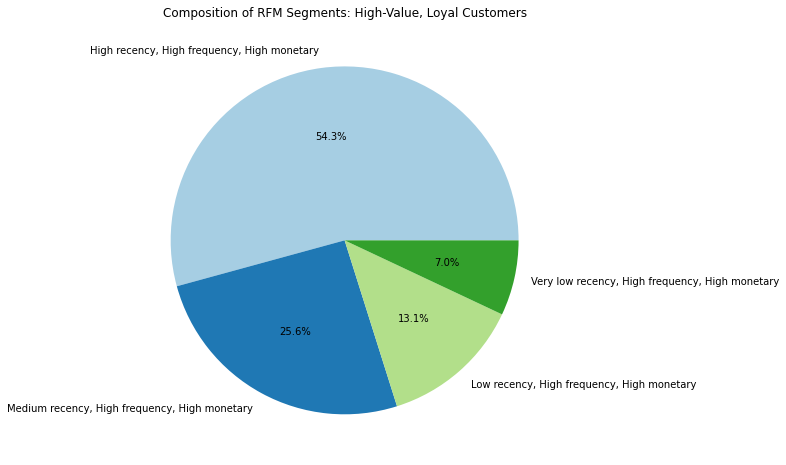

In [26]:
# Pie chart for RFM_Segment distribution who have high frequency and high monetary.

import matplotlib.pyplot as plt

s = rfm_df.loc[(rfm_df['F_score'] == 4) & (rfm_df['M_score'] == 4)]

plt.figure(figsize=(8, 8))
s['RFM_remarks'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Composition of RFM Segments: High-Value, Loyal Customers')
plt.ylabel('')
plt.show()

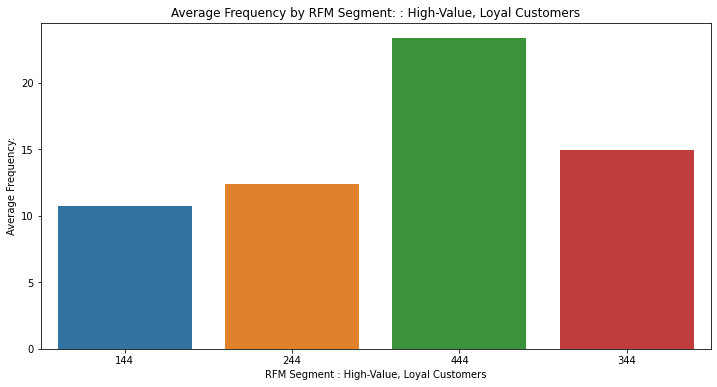

In [27]:
import seaborn as sns

# Column chart for average Frequency by RFM Segment
plt.figure(figsize=(12, 6))
sns.barplot(x='RFM_Segment', y='Frequency', data=s, ci=None)
plt.title('Average Frequency by RFM Segment: : High-Value, Loyal Customers')
plt.xlabel('RFM Segment : High-Value, Loyal Customers')
plt.ylabel('Average Frequency:')
# plt.xticks(rotation=30)
plt.show()

In [28]:
# Sharing excel files separetely for each target audience to marketing and business team.

first_seg_df.to_excel('Premium_Customer.xlsx', index = False)
sec_seg_df.to_excel('Former_Customer.xlsx', index = False)

***Upon identifying the target audience, we can propsose recommendations to the marketing and business team for long-term business success:***

#### 1.  High-Value, Loyal, and Recent Customers.
    - by offering exclusive discounts and early access to sales.
    - give rewards points for each transaction based on small or big purchase tickets.
    - Express gratitude for their loyalty and communicate upcoming offers or new product launches through email or app notification.

#### 2. High-Value, Loyal Customer who hasn't purchased recently :
    - Use platforms like social media and display ads to showcase new products, promotions, or exclusive offers.
    - Offers such as a discount on the next purchase or a freebie with their next order.